In [1]:
import os
import sys
sys.path.append('..')
from tqdm import tqdm
from datetime import datetime
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from src.support_function import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
root_1 = '../Dataset'
df_ori = pd.read_csv(os.path.join(root_1, '3bs_8q_4p_dataset_washed.csv'),
                parse_dates=['datetime'],
                 index_col = ['datetime'])
columns = ['q'+str(i) for i in range(1,12)] + ['p'+str(j) for j in range(1,8)]

FileNotFoundError: [Errno 2] File b'../Dataset\\3bs_8q_4p_dataset_washed.csv' does not exist: b'../Dataset\\3bs_8q_4p_dataset_washed.csv'

In [3]:
df = df_ori.copy()
df[columns] = normalize(df[columns])

split_point_1 = datetime.timestamp(datetime(2018,9,1))
split_point_2 = datetime.timestamp(datetime(2019,1,1))

df_train_ori = df[df['timestamp'] < split_point_1].copy()
mask1 = df['timestamp'] < split_point_2
mask2 = df['timestamp'] > split_point_1
df_valid_ori = df[mask1 & mask2].copy()
df_test_ori = df[df['timestamp'] > split_point_2].copy()

# df_test_ori = df_test_ori.iloc[1:].copy()

# 提取差分序列
df[columns] = df[columns].diff().fillna(0)
# # df = df.iloc[1:]
# df_train = df[df['timestamp'] < split_point].copy()
# df_test = df[df['timestamp'] > split_point].copy()
df_train = df[df['timestamp'] < split_point_1].copy()
mask1 = df['timestamp'] < split_point_2
mask2 = df['timestamp'] > split_point_1
df_valid = df[mask1 & mask2].copy()
df_test = df[df['timestamp'] > split_point_2].copy()

# 目标函数 q8, p5

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
def datetime_train_to_2019(x):
    return(datetime(2019,x.month,x.day,x.hour, x.minute, 0))
def datetime_train_to_2018(x):
    return(datetime(2018,x.month,x.day,x.hour, x.minute, 0))
train_decomposition = seasonal_decompose(x=df_train[columns], model='additive', freq=48)
df_train_seasonal = train_decomposition.seasonal
df_train['datetime'] = list(df_train.index)
df_train_seasonal['datetime_2019'] = df_train['datetime'].copy().apply(datetime_train_to_2019)
df_train_seasonal['datetime_2018'] = df_train['datetime'].copy().apply(datetime_train_to_2018)
df_train_resid = df_train[columns].copy() - df_train_seasonal.copy()
df_train_resid.index = df_train['datetime']

# valid_decomposition = seasonal_decompose(x=df_valid[columns], model='additive', freq=48)
df_valid_seasonal = pd.DataFrame(index=df_valid.index)
df_valid_seasonal = df_valid_seasonal.join(df_train_seasonal.copy().set_index('datetime_2018'))
df_valid_resid = df_valid[columns].copy() - df_valid_seasonal.copy()

# test_decomposition = seasonal_decompose(x=df_test[columns], model='additive', freq=48)
df_test_seasonal = pd.DataFrame(index=df_test.index)
df_test_seasonal = df_test_seasonal.join(df_train_seasonal.copy().set_index('datetime_2019'))
df_test_resid = df_test[columns].copy() - df_test_seasonal.copy()

In [5]:
df_valid_resid['q8_seasonal'] = df_valid_seasonal['q8']
df_valid_resid['q8_ori'] = df_valid_ori['q8']
df_valid_resid['p5_seasonal'] = df_valid_seasonal['p5']
df_valid_resid['p5_ori'] = df_valid_ori['p5']

df_test_resid['q8_seasonal'] = df_test_seasonal['q8']
df_test_resid['q8_ori'] = df_test_ori['q8']
df_test_resid['p5_seasonal'] = df_test_seasonal['p5']
df_test_resid['p5_ori'] = df_test_ori['p5']

In [6]:
df_valid_resid.drop(columns='datetime_2019')

p1        p2        p3        p4        p5  \
datetime                                                                
2018-09-01 00:30:00  0.291037  0.023598  0.027706  0.020595 -0.055048   
2018-09-01 01:00:00 -0.227364  0.020021  0.012979  0.037363  0.012881   
2018-09-01 01:30:00 -0.003481 -0.010326  0.003266 -0.051845  0.001288   
2018-09-01 02:00:00  0.002737 -0.004938  0.001022 -0.041111 -0.068739   
2018-09-01 02:30:00 -0.012120 -0.003824 -0.000822  0.009960  0.014074   
...                       ...       ...       ...       ...       ...   
2018-12-31 21:30:00 -0.011366 -0.033161 -0.017618 -0.046848 -0.045230   
2018-12-31 22:00:00  0.045764  0.236961  0.050854 -0.016903 -0.026010   
2018-12-31 22:30:00  0.115807 -0.138974 -0.019730  0.001783 -0.079639   
2018-12-31 23:00:00 -0.385418 -0.025691  0.092007  0.063154  0.058896   
2018-12-31 23:30:00  0.610791 -0.033459  0.213809  0.157534  0.132797   

                           p6        p7        q1       q10       q11  ...  \
datetime                                                               ...   
2018-09-01 00:30:00 -0.002879 -0.025198  0.012363 -0.008067 -0.020810  ...   
2018-09-01 01:00:00 -0.204073 -0.031953 -0.031099  0.019444 -0.010698  ...   
2018-09-01 01:30:00  0.077978  0.032618 -0.041922 -0.022019 -0.022825  ...   
2018-09-01 02:00:00  0.177111 -0.031336  0.016804 -0.004493  0.055884  ...   
2018-09-01 02:30:00 -0.089939  0.002908  0.004273 -0.015671 -0.040788  ...   
...                       ...       ...       ...       ...       ...  ...   
2018-12-31 21:30:00 -0.359181 -0.105371  0.054131  0.012333 -0.039763  ...   
2018-12-31 22:00:00 -0.003855 -0.081018  0.054716  0.033005 -0.028333  ...   
2018-12-31 22:30:00  0.058577 -0.071579  0.086857  0.062564  0.126877  ...   
2018-12-31 23:00:00 -0.151158  0.211882 -0.224035  0.062721 -0.035386  ...   
2018-12-31 23:30:00  0.019731 -0.319599  0.020310  0.114900  0.034735  ...   

                           q4        q5        q6        q7        q8  \
datetime                                                                
2018-09-01 00:30:00 -0.023211  0.047703 -0.044445  0.039548  0.000209   
2018-09-01 01:00:00 -0.007227  0.035003 -0.010739  0.098865  0.034601   
2018-09-01 01:30:00 -0.019041 -0.181020 -0.018012 -0.003323 -0.042387   
2018-09-01 02:00:00  0.004052  0.100258 -0.037332  0.033567 -0.003861   
2018-09-01 02:30:00 -0.010855  0.066696 -0.007813  0.050099 -0.021019   
...                       ...       ...       ...       ...       ...   
2018-12-31 21:30:00 -0.004108  0.006061 -0.024209  0.061385  0.008577   
2018-12-31 22:00:00  0.044387  0.024151  0.025953 -0.031149  0.014458   
2018-12-31 22:30:00  0.039973  0.038143  0.062370 -0.019910  0.061758   
2018-12-31 23:00:00  0.049888  0.017486  0.025709  0.004168  0.059251   
2018-12-31 23:30:00  0.051226  0.016002 -0.004936  0.038964  0.120083   

                           q9  q8_seasonal    q8_ori  p5_seasonal    p5_ori  
datetime                                                                     
2018-09-01 00:30:00 -0.020129    -0.062410  0.263158    -0.033273  0.447397  
2018-09-01 01:00:00  0.004306    -0.039385  0.258373    -0.000815  0.459462  
2018-09-01 01:30:00  0.006827    -0.024599  0.191388     0.008364  0.469115  
2018-09-01 02:00:00  0.043511    -0.015278  0.172249     0.002715  0.403091  
2018-09-01 02:30:00 -0.059437    -0.002905  0.148325     0.011409  0.428574  
...                       ...          ...       ...          ...       ...  
2018-12-31 21:30:00  0.014857     0.005777  0.531100     0.037122  0.698460  
2018-12-31 22:00:00  0.029945    -0.062305  0.483254     0.045701  0.718151  
2018-12-31 22:30:00  0.104699    -0.109605  0.435407    -0.024608  0.613903  
2018-12-31 23:00:00 -0.017474    -0.121452  0.373206    -0.063529  0.609270  
2018-12-31 23:30:00  0.111356    -0.110514  0.382775    -0.076040  0.666027  

[5855 rows x 22 columns]

## 检查数据集

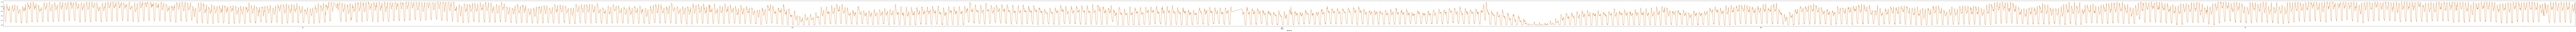

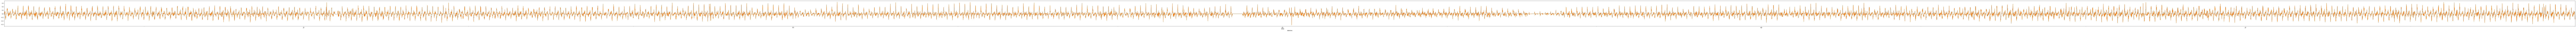

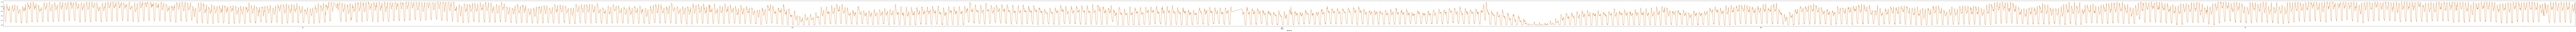

In [14]:
plt.figure(figsize=(400,4))
(df_train_resid['q8'] + df_train_seasonal['q8'] + df_train_ori['q8'].shift(1)).plot()# 验证了，没问题
df_train_ori['q8'].plot()
plt.show()
plt.figure(figsize=(400,4))
(df_train_resid['q8'] + df_train_seasonal['q8']).plot() # 验证了，没问题
df_train['q8'].plot()
plt.show()
plt.figure(figsize=(400,4))
(df_train_ori['q8'].shift(1) + df_train['q8']).plot() # 验证了，没问题
df_train_ori['q8'].plot()
plt.show()

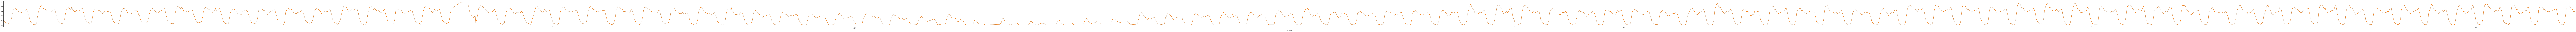

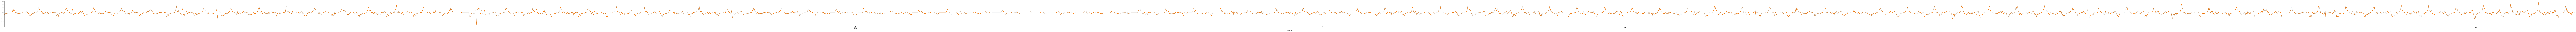

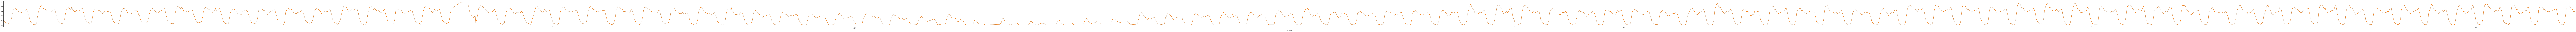

In [15]:
plt.figure(figsize=(400,4))
(df_test_resid['q8'] + df_test_seasonal['q8'] + df_test_ori['q8'].shift(1)).plot()# 验证了，没问题
df_test_ori['q8'].plot()
plt.show()
plt.figure(figsize=(400,4))
(df_test_resid['q8'] + df_test_seasonal['q8']).plot() # 验证了，没问题
df_test['q8'].plot()
plt.show()
plt.figure(figsize=(400,4))
(df_test_ori['q8'].shift(1) + df_test['q8']).plot() # 验证了，没问题
df_test_ori['q8'].plot()
plt.show()

## 检查完毕

In [27]:
df_train_resid[columns].to_csv(os.path.join(root_1, '3bs_8q_4p_train_resid.csv'))
# df_valid_resid.drop(columns='datetime_2019').to_csv(os.path.join(root_1, '3bs_8q_4p_valid_resid.csv'))
# df_test_resid.drop(columns='datetime_2018').to_csv(os.path.join(root_1, '3bs_8q_4p_test_resid.csv'))

In [15]:
# df_train_resid = pd.read_csv('../Dataset/3bs_8q_4p_train_resid.csv',
#                             parse_dates=['datetime'])

In [3]:
df_test_resid = pd.read_csv('../Dataset/3bs_8q_4p_test_resid.csv')

In [4]:
df_train_resid.shape

(29052, 19)

In [5]:
df_test_resid.shape

(4493, 23)

In [19]:
split_point = datetime(2018,9,1)
df_train_resid_2 = df_train_resid[df_train_resid['datetime']<split_point]

In [18]:
df_valid_resid.to_csv('../Dataset/3bs_8q_4p_valid_resid.csv')

In [21]:
df_train_resid_2.to_csv('..//Dataset/3bs_8q_4p_train_resid.csv')